In [6]:
import numpy as np
import scipy 
import matplotlib.pyplot as plt
import re

import pandas as pd

#can comment this in and out to make interactable
#%matplotlib widget

# Use our custom style and colours
plt.style.use('shendrukGroupStyle')
import shendrukGroupFormat as ed

from matplotlib.animation import FFMpegWriter, PillowWriter, HTMLWriter
from matplotlib.collections import LineCollection

from jones import *

In [ ]:
class polyAnalyser():
    def __init__(self, polyDataFileName, simLength, fluidDataFileName=None):
        self.polyDataFileName = polyDataFileName
        self.simLength = simLength
        self.fluidDataFileName = fluidDataFileName
        
        #extract the polymer data
        with open(self.polyDataFileName, 'r') as f:
            lines = f.readlines()
    
        #Skip header lines (first 82 lines, read empirally)
        data_lines = [line for line in lines[82:] if line.strip()]

        data = []
        current_t = 0.0
        timestep_increment = 0.1

        for line in data_lines:
            # Replace multiple spaces/tabs with single space and split
            cleaned_line = re.sub(r'\s+', ' ', line.strip())
            parts = cleaned_line.split(' ')
            
            # Check if this is a "timestep indexed" line (start of new block)
            if len(parts) >= 2 and parts[0] == 'timestep' and parts[1] == 'indexed':
                # Increment timestep for the next block
                current_t = round(current_t + timestep_increment, 10)
                continue  # Skip this header line
            
            # Process data lines (monomer index, x, y, z)
            if len(parts) >= 4:
                try:
                    data.append({
                        't': current_t,
                        'monomerIndex': int(parts[0]),
                        'x': float(parts[1]),
                        'y': float(parts[2]),
                        'z': float(parts[3]),
                    })
                except ValueError:
                    # Skip lines that can't be parsed as numbers
                    continue
    
        self.polyData=pd.DataFrame(data)
    

    def makeMovie(self, axesLim, twoDimensional=False):
        writer = FFMpegWriter(fps=10, bitrate=10000)
        output_file = 'particle_animation.mp4'

        fig = plt.figure(figsize=(10, 8))
        if not twoDimensional:
            ax = fig.add_subplot(111, projection='3d')
        else:
            ax = fig.add_subplot(111)  # Regular 2D axes

        with writer.saving(fig, output_file, dpi=100):
            for i in range(1, self.simLength + 1):
                t = i / 10
                print('Currently processing frame at t = ', t)
                
                monomerData = self.polyData[self.polyData['t'] == t].sort_values('monomerIndex')
                monoX = monomerData['x']
                monoY = monomerData['y']
                monoZ = monomerData['z']

                ax.clear()

                if len(monoX) > 1:
                    colors = plt.cm.rainbow(np.linspace(0, 1, len(monoX) - 1))
                    point_colors = plt.cm.rainbow(np.linspace(0, 1, len(monoX)))
                    
                    # Plot segments - DIFFERENT FOR 2D vs 3D
                    for j in range(len(monoX) - 1):
                        if twoDimensional:
                            # 2D: only use x and y
                            ax.plot(monoX[j:j+2], monoY[j:j+2], 
                                    color=colors[j], linewidth=3, alpha=0.8)
                        else:
                            # 3D: use x, y, z
                            ax.plot(monoX[j:j+2], monoY[j:j+2], monoZ[j:j+2],
                                    color=colors[j], linewidth=3, alpha=0.8)
                    
                    # Plot points - DIFFERENT FOR 2D vs 3D
                    if twoDimensional:
                        ax.scatter(monoX, monoY, c=point_colors, s=10, alpha=1, 
                                edgecolors='black', linewidth=0.5)
                        ax.set_xlabel('X')
                        ax.set_ylabel('Y')
                        ax.grid(True)
                        # NO z-label in 2D mode - removed the problematic line
                    else:
                        ax.scatter(monoX, monoY, monoZ, c=point_colors, s=40, alpha=1,
                                edgecolors='black', linewidth=0.5)
                        ax.set_xlabel('X')
                        ax.set_ylabel('Y')
                        ax.set_zlabel('Z')  # This line only runs in 3D mode
                        ax.grid(True)

                    # Set equal aspect ratio for 2D
                    if twoDimensional:
                        ax.set_aspect('equal')
                    
                    # Set axis limits if provided
                    if axesLim is not None:
                        ax.set_xlim(0, axesLim)  # Assuming axesLim is box size
                        ax.set_ylim(0, axesLim)
                        if not twoDimensional:
                            ax.set_zlim(0, axesLim)

                ax.set_title(f'Particle Positions at t = {t:.1f}')
                writer.grab_frame()
    

    #plots and returns data if you want to compare several simulations
    def plotAvgMonomerSpeeds(self):
        avgSpeedData=[]
        #loop between second and last-1 time frame 
        for i in range(2, self.simLength):
                #calculate t value from i (dividing instead of multiplying as avoids floating point errors)
                t=i/10
                tPrev=(i-1)/10

                dt=t-tPrev

                #previous monomerInfo
                monomerData = self.polyData[self.polyData['t'] == tPrev].sort_values('monomerIndex') #new line
                prevMonoX=self.polyData[self.polyData['t']==tPrev]['x']
                prevMonoY=self.polyData[self.polyData['t']==tPrev]['y']
                prevMonoZ=self.polyData[self.polyData['t']==tPrev]['z']

                #monomerInfo
                monomerData = self.polyData[self.polyData['t'] == t].sort_values('monomerIndex') #new line
                monoX=self.polyData[self.polyData['t']==t]['x']
                monoY=self.polyData[self.polyData['t']==t]['y']
                monoZ=self.polyData[self.polyData['t']==t]['z']

              
                #print(monoX.values - prevMonoX.values, 'difference in X for 1 timestep  ')

                #calculate speeds
                speeds=np.sqrt((monoX.values - prevMonoX.values)**2 + (monoY.values - prevMonoY.values)**2 + (monoZ.values - prevMonoZ.values)**2)/dt
                #print(speeds, 'speeds')
                avgSpeed=np.mean(speeds)
                avgSpeedData.append(avgSpeed)
        
        plt.plot(range(self.simLength-2), avgSpeedData)
        plt.xlabel('Time step')
        plt.ylabel('Average monomer speed')
        plt.title('Average Monomer Speed vs Time')
        plt.show()

        return avgSpeedData
    

    #using Caleb Musfeldt & Kasturi Jones Polynomial Analysis Code (Recursive, not good for long polymers)
    def getUnknotTime(self):
        #loop through simulation timesteps

        #originally looped through backwards to try and avoid checking all early timesteps, but if monomer has funky blow up conditions, checker doesn't like
        for i in range(1,self.simLength):
        #for i in range(1, 10):
            t=i/10
            #print(t)
            monomerData = self.polyData[self.polyData['t'] == t].sort_values('monomerIndex')
            
            #get coord data for checking
            monoX=self.polyData[self.polyData['t']==t]['x']
            monoY=self.polyData[self.polyData['t']==t]['y']
            monoZ=self.polyData[self.polyData['t']==t]['z']

            #print(monoX)

            #put coordinates into format
            coordinates = np.column_stack([monoX, monoY, monoZ])
            jonesInput = np.array([coordinates], dtype=object)

            #print(jonesInput)

            #calculating
            jonesPolynomial=expected_jones(jonesInput, 1)

            #print(jonesPolynomial, 'jonespoly')

            
            #check if unknotting
            if jonesPolynomial== {0: np.float64(1.0)}:
                print(jonesPolynomial, 'found unknotting at t= ', t)

                #threshold for false positives at early time dynamics, value is empirical and should think harder about this
                if t<1:
                    pass
                else:
                    unknotTime=t
                    break
        
        return unknotTime

Currently processing frame at t =  0.0
Currently processing frame at t =  0.1
Currently processing frame at t =  0.2
Currently processing frame at t =  0.3
Currently processing frame at t =  0.4
Currently processing frame at t =  0.5
Currently processing frame at t =  0.6
Currently processing frame at t =  0.7
Currently processing frame at t =  0.8
Currently processing frame at t =  0.9
Currently processing frame at t =  1.0
Currently processing frame at t =  1.1
Currently processing frame at t =  1.2
Currently processing frame at t =  1.3
Currently processing frame at t =  1.4
Currently processing frame at t =  1.5
Currently processing frame at t =  1.6
Currently processing frame at t =  1.7
Currently processing frame at t =  1.8
Currently processing frame at t =  1.9
Currently processing frame at t =  2.0
Currently processing frame at t =  2.1
Currently processing frame at t =  2.2
Currently processing frame at t =  2.3
Currently processing frame at t =  2.4
Currently processing fram

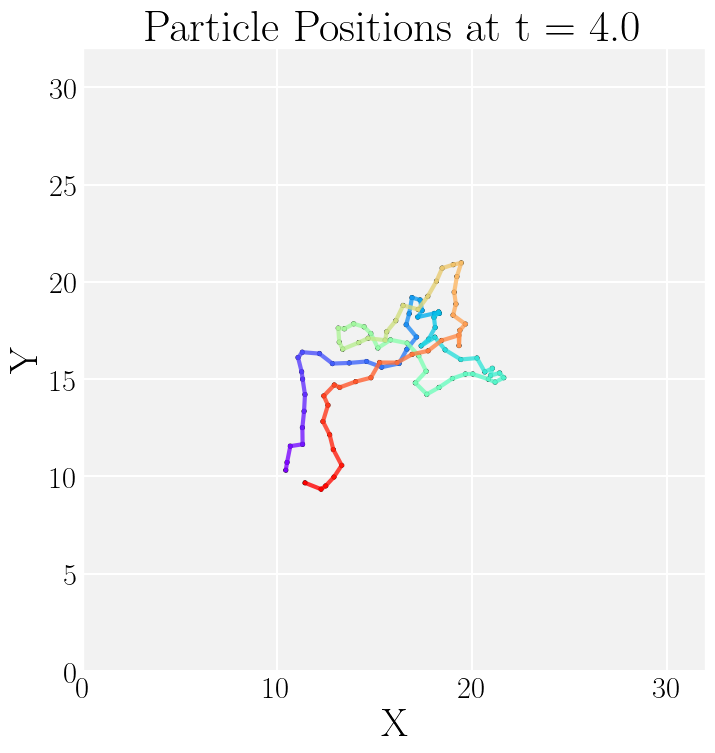

In [24]:
#length is 6000, but set to 10 for now to conduct testing on kymo conversion function
a=polyAnalyser('/Users/johnwhitfield/Desktop/localSims/n100Testing/output/20251118-84166/20251118-84166-vmd.vtf', 40)

#a.convert_to_lammps('/Users/johnwhitfield/Desktop/polyAnalyser/convertedFrames')
a.makeMovie(32, twoDimensional=True)

#print(unKnotTime)
